<a href="https://colab.research.google.com/github/Ranim-Mattoussi/Twitter-analyse-des-sentiments/blob/main/Twitter_analyse_des_sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Importation des bibliothèques**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import warnings
import re
import string
import random

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')

# **Chargement des données**

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 174MB/s]


In [ ]:
!unzip /content/twitter-entity-sentiment-analysis.zip -d /content/dataset

Archive:  /content/twitter-entity-sentiment-analysis.zip
  inflating: /content/dataset/twitter_training.csv  
  inflating: /content/dataset/twitter_validation.csv  


In [ ]:
!rm -rf /content/drive/MyDrive/dataset
!mv /content/dataset /content/drive/MyDrive/dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/twitter_training.csv')

# **Exploration initiale des données**

Aperçu du dataset

In [ ]:
df.sample(7)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
30597,7257,LeagueOfLegends,Negative,"@LeagueOfLegends please, please, please please..."
42607,10110,PlayerUnknownsBattlegrounds(PUBG),Neutral,Yours fav weapon from pubg?
67553,7170,johnson&johnson,Neutral,. Internship Spotlight.
12914,8619,NBA2K,Negative,@NBA2K: REALLY you guy won't give the old reti...
38727,5444,Hearthstone,Positive,I definitely miss Hearthstone and Overwatch do...
22808,4308,CS-GO,Positive,Help me win this coveted CS:GO prize from Idle...
39786,1231,Battlefield,Negative,"If this was posted a few decades ago, you woul..."


In [ ]:
# Affiche la forme du DataFrame 'df' (nombre de lignes et de colonnes).
print(f'The shape of the dataset is : {df.shape}')

The shape of the dataset is : (74681, 4)


In [ ]:
# Affiche les noms des colonnes du DataFrame 'df'.
print(f'The columns are :{df.columns}')

The columns are :Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')


In [ ]:
# Affiche les types de données de chaque colonne du DataFrame 'df'.
print(f'The dtypes of the dataset : \n\n{df.dtypes}')

The dtypes of the dataset : 

2401                                                      int64
Borderlands                                              object
Positive                                                 object
im getting on borderlands and i will murder you all ,    object
dtype: object


In [ ]:
# Affiche un résumé statistique de toutes les colonnes du DataFrame 'df',
# y compris les variables numériques et non numériques (catégorielles).
df.describe(include='all')

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
count,74681.000000,74681,74681,73995
unique,NaN,32,4,69490
top,NaN,Microsoft,Negative,
freq,NaN,2400,22542,172
mean,6432.640149,NaN,NaN,NaN
std,3740.423819,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN


In [ ]:
# Fonction qui retourne le nombre et le pourcentage de valeurs manquantes et dupliquées par colonne.
def show_details(dataset):
    missed_values = dataset.isnull().sum()  # Valeurs manquantes
    missed_values_percent = (dataset.isnull().sum()) / len(dataset)  # Pourcentage de manquantes
    duplicated_values = dataset.duplicated().sum()  # Valeurs dupliquées
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)  # Pourcentage de dupliquées

    # Crée et retourne un DataFrame transposé avec ces informations
    info_frame = pd.DataFrame({'Missed_Values' : missed_values ,
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})

    return info_frame.T

In [ ]:
# Appelle la fonction 'show_details' pour afficher les informations sur les valeurs manquantes
# et dupliquées du DataFrame 'df'.
show_details(df)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
Missed_Values,0.000000,0.000000,0.000000,686.000000
Missed_Values %,0.000000,0.000000,0.000000,0.009186
Duplicated values,2700.000000,2700.000000,2700.000000,2700.000000
Duplicated values %,0.036154,0.036154,0.036154,0.036154


Nettoyage

In [ ]:
# Supprime les doublons du DataFrame 'df' en place.
df.drop_duplicates(inplace=True)

# Supprime les lignes contenant des valeurs manquantes du DataFrame 'df' en place.
df.dropna(inplace=True)

# Affiche les détails sur les valeurs manquantes et dupliquées après nettoyage.
show_details(df)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
Missed_Values,0.0,0.0,0.0,0.0
Missed_Values %,0.0,0.0,0.0,0.0
Duplicated values,0.0,0.0,0.0,0.0
Duplicated values %,0.0,0.0,0.0,0.0


In [ ]:
# Renomme les colonnes du DataFrame 'df' en place selon les correspondances spécifiées.
df.rename(columns={'2401' : 'Index' , 'Borderlands': 'Land' , 'Positive' : 'Mode'
                   , "im getting on borderlands and i will murder you all ,": 'Text'}, inplace=True)

In [ ]:
df.columns

Index(['Index', 'Land', 'Mode', 'Text'], dtype='object')

# **Analyse exploratoire des données (EDA)**

In [ ]:
# Affiche le nombre de valeurs uniques dans la colonne 'Land' du DataFrame 'df'.
print(f'The number of unique lands : {len(df.Land.unique())}')

# Affiche une séparation visuelle.
print('**' * 40)

# Affiche les valeurs uniques dans la colonne 'Land' du DataFrame 'df'.
df.Land.unique()

The number of unique lands : 32
********************************************************************************


array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [ ]:
# Calcule le nombre d'occurrences de chaque valeur unique dans la colonne 'Land'
# et le stocke dans la variable 'lands'.
lands = df.Land.value_counts()

# Convertit la série 'lands' en DataFrame pour un affichage plus lisible.
lands.to_frame()

,count
Land,
TomClancysRainbowSix,2328
Verizon,2319
MaddenNFL,2315
CallOfDuty,2314
Microsoft,2304
WorldOfCraft,2300
NBA2K,2299
LeagueOfLegends,2296
TomClancysGhostRecon,2291


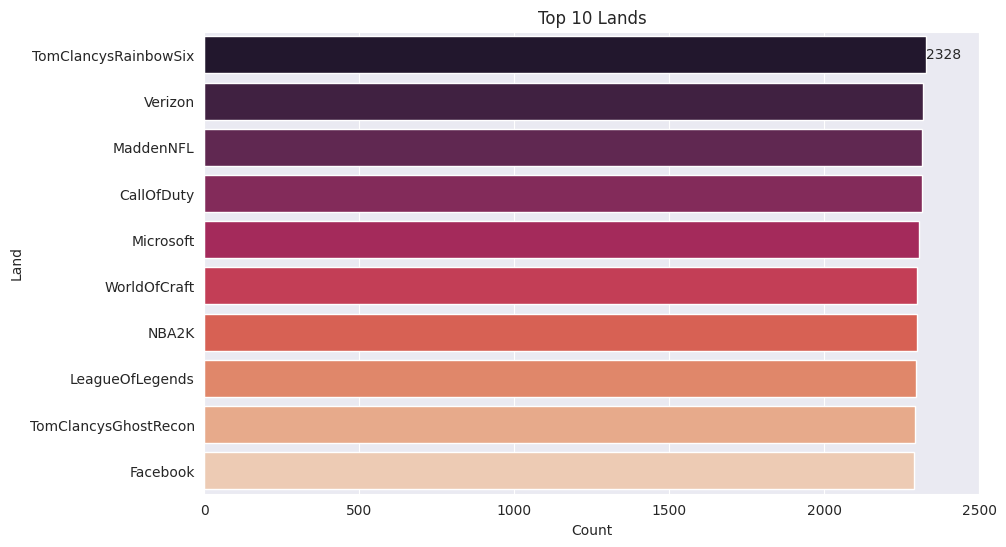

In [ ]:
# Définit le style de la grille de Seaborn à 'darkgrid' pour une visualisation avec une grille sombre.
sns.set_style('darkgrid')

# Crée une figure de taille 10x6 pour le graphique.
plt.figure(figsize=(10, 6))

# Crée un graphique à barres avec les 10 premières valeurs de 'lands' et utilise la palette 'rocket'.
bar = sns.barplot(x=lands.values[:10], y=lands.index[:10], palette='rocket')

# Ajoute les labels des barres pour indiquer les valeurs.
bar.bar_label(bar.containers[0])

# Définit le titre, les étiquettes des axes, et les limites de l'axe X.
plt.title('Top 10 Lands')
plt.xlabel('Count')
plt.ylabel('Land')
plt.xlim(0, 2500)

# Affiche le graphique.
plt.show()

In [ ]:
# Affiche le nombre de valeurs uniques dans la colonne 'Mode' du DataFrame 'df'.
print(f'The unique values of Mode : {len(df.Mode.unique())}')

# Affiche une séparation visuelle.
print('**' * 20)

# Affiche les valeurs uniques présentes dans la colonne 'Mode' du DataFrame 'df'.
print(df.Mode.unique())

The unique values of Mode : 4
****************************************
['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [ ]:
# Calcule le nombre d'occurrences de chaque valeur unique dans la colonne 'Mode'
# et le stocke dans la variable 'mode'.
mode = df.Mode.value_counts()

# Convertit la série 'mode' en DataFrame et transpose le résultat pour un affichage plus lisible.
mode.to_frame().T

Mode,Negative,Positive,Neutral,Irrelevant
count,21698,19712,17708,12537


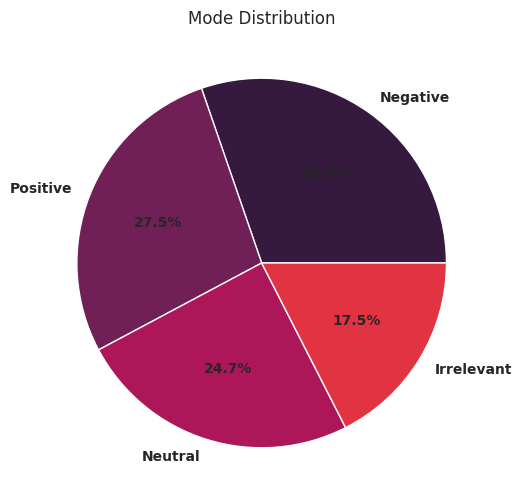

In [ ]:
# Crée une figure de taille 6x6 pour le graphique circulaire (camembert).
plt.figure(figsize=(6, 6))

# Crée le graphique en camembert avec les valeurs de 'mode' et ses clés comme labels.
# Le pourcentage est affiché avec une précision d'une décimale,
# et les propriétés du texte sont ajustées (taille de police et poids de la police).
plt.pie(x=mode.values, labels=mode.keys(), autopct="%1.1f%%",
        textprops={"fontsize": 10, "fontweight": "black"},
        colors=sns.color_palette("rocket"))

# Ajoute un titre au graphique.
plt.title('Mode Distribution')

# Affiche le graphique.
plt.show()

In [ ]:
# Crée un tableau croisé (crosstab) entre les colonnes 'Mode' et 'Land' du DataFrame 'df'.
# La méthode 'T' transpose le tableau pour que les lignes deviennent des colonnes et vice versa.
# Les valeurs sont ensuite stylisées avec un dégradé de couleurs spécifiques pour chaque sous-ensemble.

pd.crosstab(df.Mode , df.Land).T.style.background_gradient( subset=['Negative'],cmap='Reds')\
.background_gradient(subset=['Positive'] , cmap='Greens')\
.background_gradient(subset=['Irrelevant'] , cmap='BuGn')

Mode,Irrelevant,Negative,Neutral,Positive
Land,,,,
Amazon,185,565,1197,302
ApexLegends,185,574,913,606
AssassinsCreed,256,365,153,1382
Battlefield,907,445,342,561
Borderlands,238,415,581,971
CS-GO,620,335,523,717
CallOfDuty,660,861,367,426
CallOfDutyBlackopsColdWar,545,540,340,817
Cyberpunk2077,457,360,456,902


# **Prétraitement des textes**

In [ ]:
def clean_emoji(tx):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols
                           u"\U0001F680-\U0001F6FF"  # transport
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', tx)
def text_cleaner(tx):

    text = re.sub(r"won\'t", "would not", tx)
    text = re.sub(r"im", "i am", tx)
    text = re.sub(r"Im", "I am", tx)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)

    return text


In [ ]:
random.seed(99)  # Fixe la graine du générateur de nombres aléatoires à 99, assurant ainsi la reproductibilité des résultats
test_text = text_cleaner(random.choice(df['Text']))  # Sélectionne un texte aléatoire dans la colonne 'Text' du DataFrame 'df' et applique la fonction 'text_cleaner' pour nettoyer ce texte
test_text = clean_emoji(test_text)  # Applique la fonction 'clean_emoji' pour supprimer les émojis du texte nettoyé
test_text  # Affiche le texte final après nettoyage


'ghost of tsushima is now graphically the best open world. red dead redemption 2 is one second ahead.'

In [ ]:
doc = nlp(test_text)  # Applique le modèle 'nlp' de spaCy au texte nettoyé 'test_text' pour effectuer l'analyse linguistique
for token in doc:  # Itère sur chaque token (mot ou signe de ponctuation) dans le document
    print(f'{token} => {token.pos_}')  # Affiche le token (mot) et sa partie du discours associée (par exemple, nom, verbe, adjectif, etc.)

ghost => NOUN
of => ADP
tsushima => PROPN
is => AUX
now => ADV
graphically => ADV
the => DET
best => ADV
open => ADJ
world => NOUN
. => PUNCT
red => ADJ
dead => ADJ
redemption => NOUN
2 => NUM
is => AUX
one => NUM
second => ADJ
ahead => ADV
. => PUNCT


In [ ]:
doc = nlp(test_text)  # Applique le modèle 'nlp' de spaCy au texte nettoyé 'test_text' pour effectuer l'analyse linguistique
for chunk in doc.ents:  # Itère sur chaque entité nommée (chunks) dans le document
    print(f'{chunk} => {chunk.label_}')  # Affiche l'entité nommée et son type (label_), par exemple "PERSON", "ORG", "GPE", etc.


tsushima => GPE
2 => CARDINAL
second => ORDINAL


In [ ]:
doc = nlp(test_text)  # Applique le modèle 'nlp' de spaCy au texte nettoyé 'test_text' pour effectuer l'analyse linguistique
for chunk in doc.noun_chunks:  # Itère sur chaque groupe nominal (noun chunk) dans le document
    print(f'{chunk} => {chunk.label_}')  # Affiche le groupe nominal et son étiquette (label_)


ghost => NP
tsushima => NP
the best open world => NP
red dead redemption => NP


In [ ]:
Tokenizer = RegexpTokenizer(r'\w+')  # Crée une instance de RegexpTokenizer avec une expression régulière pour extraire des mots (alphanumériques)
test_text_tokenized = Tokenizer.tokenize(test_text)  # Applique la tokenisation sur 'test_text'
test_text_tokenized  # Affiche la liste des tokens (mots) obtenus


['ghost',
 'of',
 'tsushima',
 'is',
 'now',
 'graphically',
 'the',
 'best',
 'open',
 'world',
 'red',
 'dead',
 'redemption',
 '2',
 'is',
 'one',
 'second',
 'ahead']

# **Visualisation des fréquences des mots**

array([[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

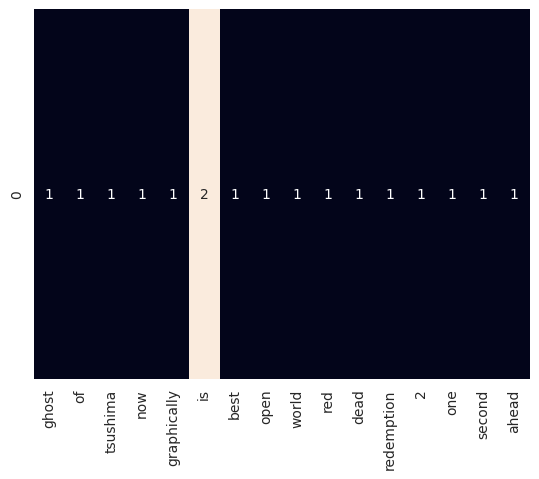

In [ ]:
words  = ['ghost','of','tsushima','now','graphically','is','best','open','world','red','dead','redemption','2','one','second','ahead']
counter_vectorizer = CountVectorizer()
transform = counter_vectorizer.fit_transform([test_text]).toarray()
sns.heatmap(transform, annot=True,xticklabels=words,
        cbar=False)
transform

array([[0.22941573, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
        0.45883147, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
        0.22941573, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
        0.22941573]])

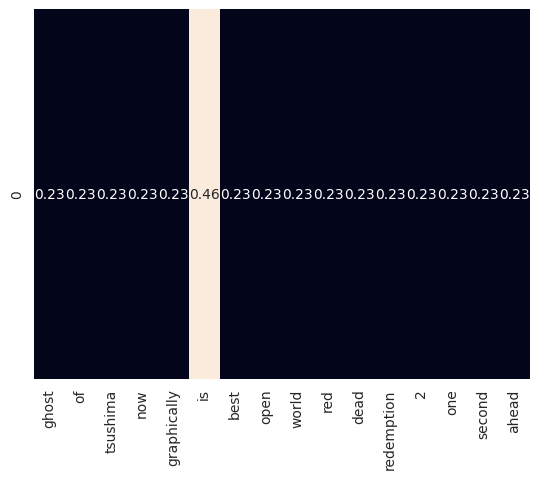

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
words  = ['ghost','of','tsushima','now','graphically','is','best','open','world','red','dead','redemption','2','one','second','ahead']
TF_IDF = TfidfVectorizer()
transform = TF_IDF.fit_transform([test_text]).toarray()
sns.heatmap(transform, annot=True,xticklabels=words,
        cbar=False)
transform

# **n-grams**



In [ ]:
def n_grams(text, n):
    # Crée une liste de n-grammes à partir du texte donné
    return [text[i:i+n] for i in range(len(text)-n+1)]

cleaned = test_text_tokenized
# Génère les trigrammes (n=3) à partir du texte nettoyé
n_grams(cleaned, 3)


[['ghost', 'of', 'tsushima'],
 ['of', 'tsushima', 'is'],
 ['tsushima', 'is', 'now'],
 ['is', 'now', 'graphically'],
 ['now', 'graphically', 'the'],
 ['graphically', 'the', 'best'],
 ['the', 'best', 'open'],
 ['best', 'open', 'world'],
 ['open', 'world', 'red'],
 ['world', 'red', 'dead'],
 ['red', 'dead', 'redemption'],
 ['dead', 'redemption', '2'],
 ['redemption', '2', 'is'],
 ['2', 'is', 'one'],
 ['is', 'one', 'second'],
 ['one', 'second', 'ahead']]

# **Stopwords et Stemming**

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Importation de la liste des mots vides (stop words) en anglais à partir de NLTK
stopwords_list = stopwords.words('english')

# Affichage du nombre total de mots vides
print(f'There are {len(stopwords_list)} stop words')

# Séparation visuelle dans la sortie
print('**' * 20 , '\n20 of them are as follows:\n')

# Affichage des 20 premiers mots vides avec leur index
for inx , value in enumerate(stopwords_list[:20]):
    print(f'{inx+1}: {value}')



There are 179 stop words
**************************************** 
20 of them are as follows:

1:i
2:me
3:my
4:myself
5:we
6:our
7:ours
8:ourselves
9:you
10:you're
11:you've
12:you'll
13:you'd
14:your
15:yours
16:yourself
17:yourselves
18:he
19:him
20:his


In [ ]:
def make_corpus(kind):
    # Initialise une liste vide pour stocker les mots du corpus
    corpus = []

    # Parcourt les lignes du DataFrame où la colonne 'Mode' correspond à la valeur 'kind'
    # Chaque ligne contient une liste de mots dans la colonne 'Text'
    for text in df.loc[df['Mode'] == kind]['Text'].str.split():
        # Ajoute chaque mot du texte dans le corpus
        for word in text:
            corpus.append(word)

    # Retourne la liste finale du corpus
    return corpus


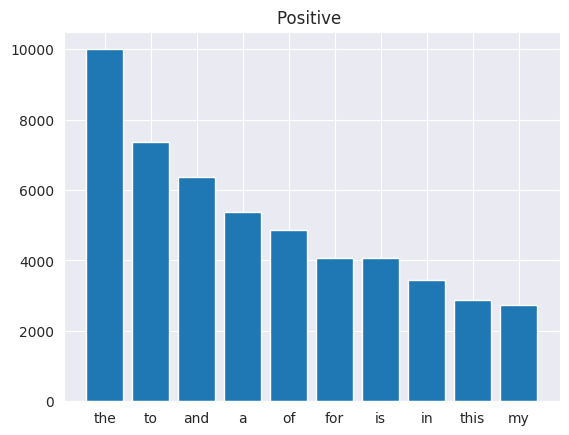

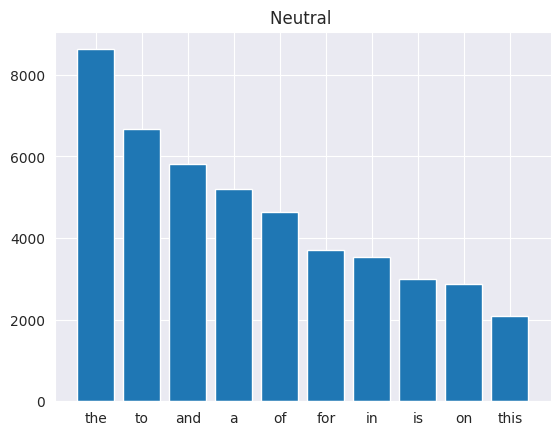

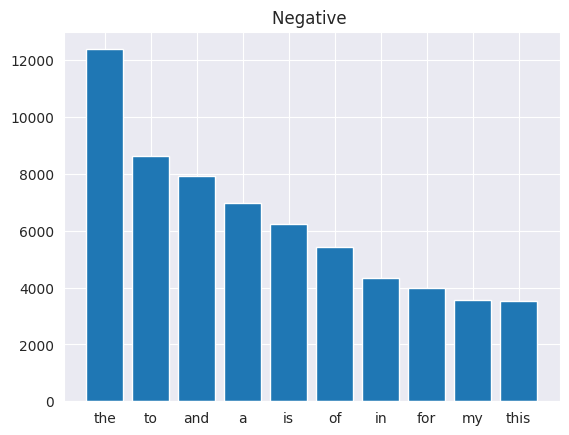

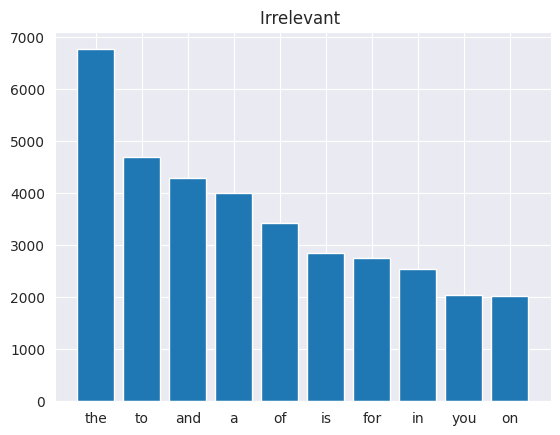

CPU times: user 6.6 s, sys: 250 ms, total: 6.85 s
Wall time: 6.92 s


In [ ]:
%%time
stop = stopwords.words('english')
sentiments = list(df.Mode.unique())



for inx , value in enumerate(sentiments):

    corpus = make_corpus(value)

    dic = defaultdict(int)

    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

    x, y = zip(*top)
    plt.title(f'{value} ')
    plt.bar(x , y)
    plt.show()

In [ ]:
# Applique la fonction 'text_cleaner' à chaque élément de la colonne 'Text'
# Cela permet de nettoyer chaque texte (par exemple, supprimer les ponctuations, les emojis, etc.)
df['Text'] = df['Text'].apply(lambda x : text_cleaner(x))

# Applique la fonction 'Tokenizer.tokenize' à chaque texte nettoyé pour le diviser en une liste de mots
# Chaque texte est maintenant représenté sous forme d'une liste de tokens
df['Text'] = df['Text'].apply(lambda x : Tokenizer.tokenize(x))

# Convertit la colonne 'Text' en un DataFrame pour affichage ou manipulation supplémentaire
df['Text'].to_frame()



,Text
0,"[i, am, coming, to, the, borders, and, i, will..."
1,"[im, getting, on, borderlands, and, i, will, k..."
2,"[im, coming, on, borderlands, and, i, will, mu..."
3,"[im, getting, on, borderlands, 2, and, i, will..."
4,"[im, getting, into, borderlands, and, i, can, ..."
...,...
74676,"[just, realized, that, the, windows, partition..."
74677,"[just, realized, that, my, mac, window, partit..."
74678,"[just, realized, the, windows, partition, of, ..."
74679,"[just, realized, between, the, windows, partit..."


In [ ]:
# Chargement du modèle linguistique spaCy en anglais
nlp = spacy.load("en_core_web_sm")

# Applique le modèle spaCy au texte 'test_text' pour obtenir un objet 'doc' contenant toutes les informations linguistiques
doc = nlp(test_text)

# Parcourt chaque token dans le document (chaque mot ou ponctuation)
# Affiche le token original et son lemme (forme de base du mot) grâce à la propriété 'lemma_'
for token in doc:
    print(f'{token} => {token.lemma_}')


ghost => ghost
of => of
tsushima => tsushima
is => be
now => now
graphically => graphically
the => the
best => well
open => open
world => world
. => .
red => red
dead => dead
redemption => redemption
2 => 2
is => be
one => one
second => second
ahead => ahead
. => .


In [ ]:
# Initialisation du stemmer de Porter.
Stemmer = PorterStemmer()

# Fonction pour supprimer les stopwords et appliquer un stemming.
def stopwords_cleaner(text):
    word = [Stemmer.stem(letter) for letter in text if letter not in stopwords_list]
    peasting = ' '.join(word)
    return peasting

# Applique la fonction de nettoyage sur chaque texte de la colonne 'Text'.
df['Text'] = df['Text'].apply(lambda x : stopwords_cleaner(x))


In [ ]:
df['Text'][:10].to_frame()

,Text
0,come border kill
1,im get borderland kill
2,im come borderland murder
3,im get borderland 2 murder
4,im get borderland murder
5,spent hour make someth fun know huge borderlan...
6,spent coupl hour someth fun know huge borderla...
7,spent hour someth fun know huge borderland fan...
8,spent hour make someth fun know huge rhandlerr...
9,2010 spent hour make someth fun know huge rhan...


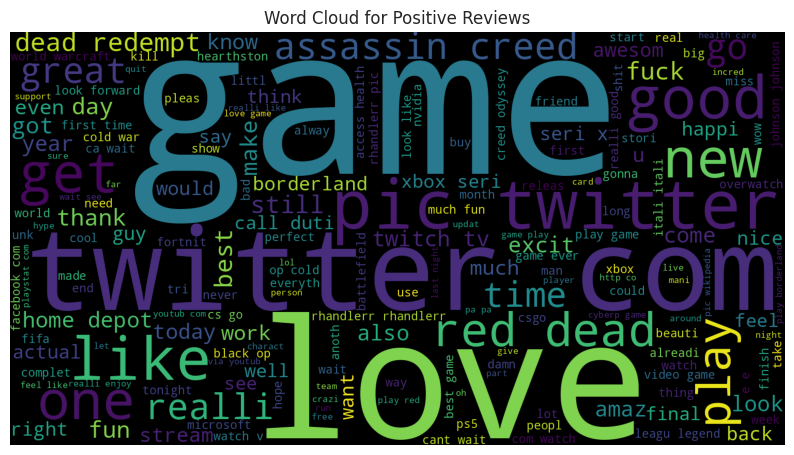

CPU times: user 3.1 s, sys: 210 ms, total: 3.31 s
Wall time: 3.2 s


In [ ]:
%%time
positive_reviews = df[df['Mode'] == 'Positive']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()


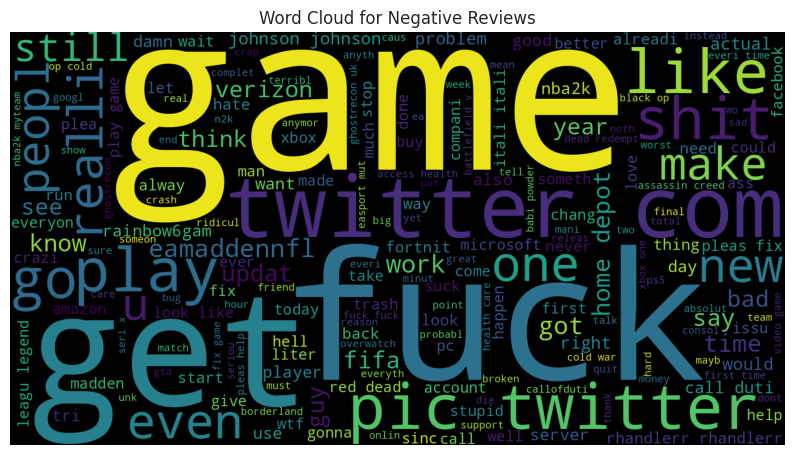

CPU times: user 3.81 s, sys: 139 ms, total: 3.95 s
Wall time: 3.98 s


In [ ]:
%%time
positive_reviews = df[df['Mode'] == 'Negative']['Text']
neg = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(neg)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

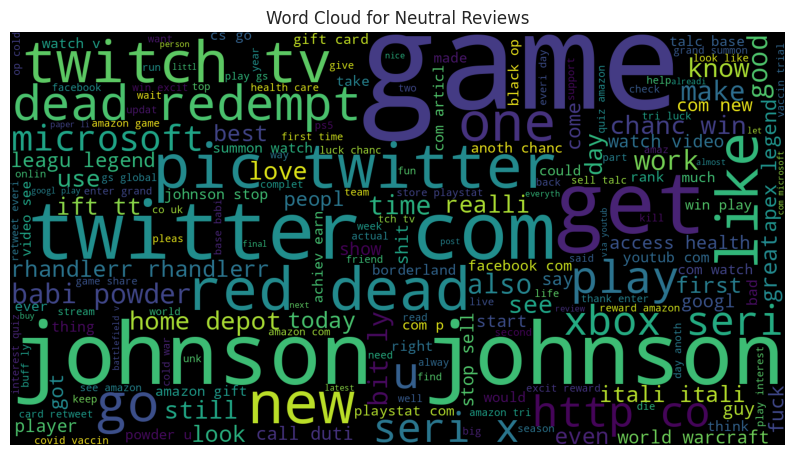

CPU times: user 4.9 s, sys: 163 ms, total: 5.06 s
Wall time: 5.27 s


In [ ]:
%%time
positive_reviews = df[df['Mode'] == 'Neutral']['Text']
Neutral = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(Neutral)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Neutral Reviews')
plt.axis('off')
plt.show()

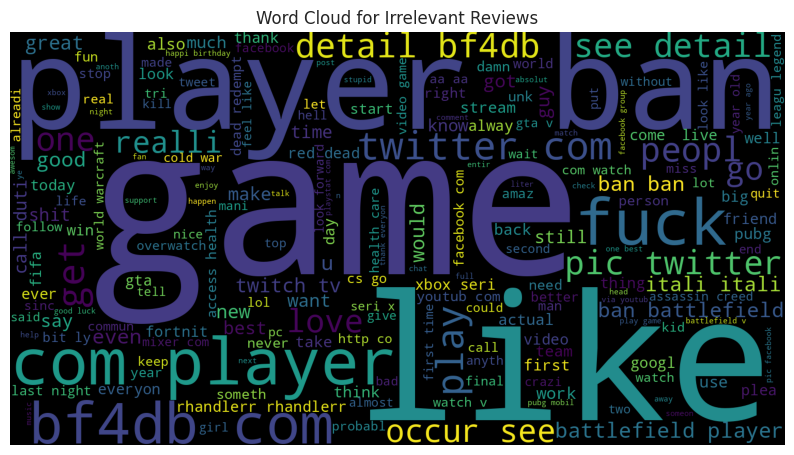

CPU times: user 3.73 s, sys: 198 ms, total: 3.92 s
Wall time: 3.85 s


In [ ]:
%%time
positive_reviews = df[df['Mode'] == 'Irrelevant']['Text']
Irrelevant  = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(Irrelevant )
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Irrelevant Reviews')
plt.axis('off')
plt.show()

In [ ]:
len_text = [len(tx) for tx in df['Text'].to_list()]
print(f'Max Length : {np.max(len_text)}')
print(f'Min Length : {np.min(len_text)}')
print(f'Mean Length : {round(np.mean(len_text),2)}')
print(f'Std Length : {round(np.std(len_text),2)}')
print(f'Mew + 2sigma : {round(np.mean(len_text)+ 2 *np.std(len_text),2)}')


Max Length : 797
Min Length : 0
Mean Length : 67.68
Std Length : 49.01
Mew + 2sigma : 165.7


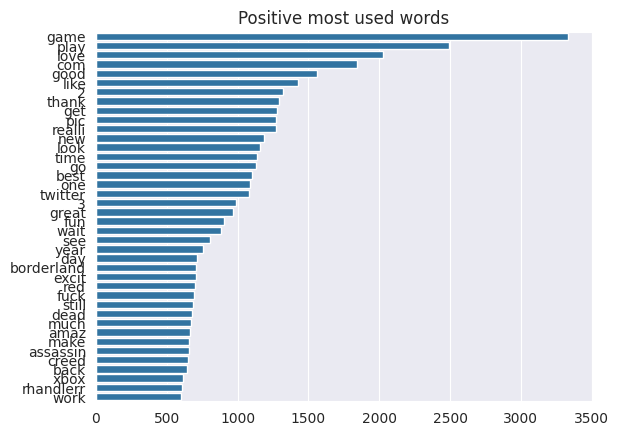

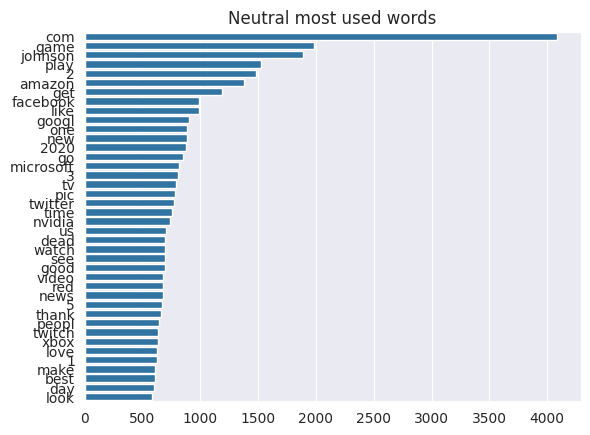

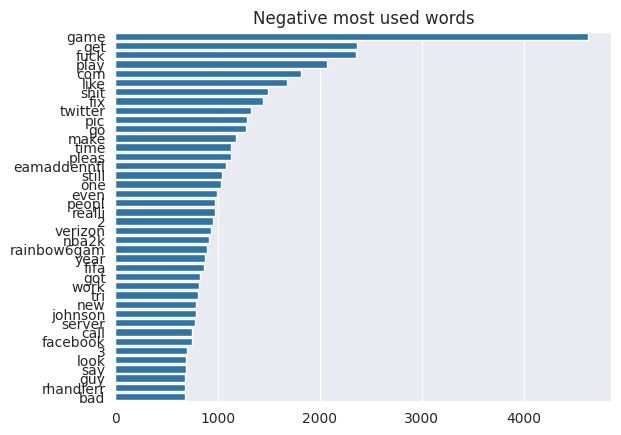

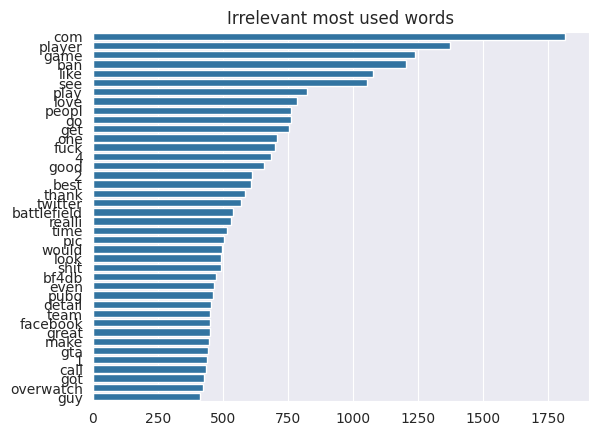

CPU times: user 2.35 s, sys: 473 ms, total: 2.82 s
Wall time: 2.3 s


In [ ]:
%%time
for inx , value in enumerate(sentiments):

    counter = Counter(make_corpus(value))
    most_common = counter.most_common()

    x = []
    y = []

    for word, count in most_common[:40]:
         if word not in stop:
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, orient='h')
    plt.title(f'{value} most used words')
    plt.show()

# **Préparation des données pour le modèle BiLSTM**

In [ ]:
df['sentiments'] = df['Mode'].replace({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

In [ ]:
df.sample(10)

,Index,Land,Mode,Text,sentiments
36752,8305,Microsoft,Negative,suspicion anger toward window window 10 search...,0
28133,443,ApexLegends,Positive,wow,1
58388,3211,Facebook,Irrelevant,actual nice happi thank guardian angel,2
21478,4076,CS-GO,Irrelevant,happi hiiim,2
22605,4270,CS-GO,Irrelevant,best luke come back even stronger actual prett...,2
46333,11951,Verizon,Neutral,spectrum definit worst internet anyon want sta...,2
19442,12529,WorldOfCraft,Neutral,thank callmequestif evildcrab warcraft blizzco...,2
6191,266,Amazon,Negative,amazon believ poor tast horrif exploit man dea...,0
14871,2947,Dota2,Positive,damn r6 final hit tier one feel fuck great,1
45165,11755,Verizon,Neutral,onesearch verizon word media new public search...,2


In [ ]:
class Dataset:
    # Initialisation avec du texte et des sentiments.
    def __init__(self, text, sentiment):
        self.text = text  # Liste de textes
        self.sentiment = sentiment  # Liste des sentiments correspondants

    # Renvoie la longueur du dataset.
    def __len__(self):
        return len(self.text)

    # Accès à un élément du dataset (text et sentiment).
    def __getitem__(self, item):
        text = self.text[item, :]  # Récupère le texte à l'index 'item'
        target = self.sentiment[item]  # Récupère le sentiment à l'index 'item'
        return {
            "text": torch.tensor(text, dtype=torch.long),  # Convertit en tensor PyTorch
            "target": torch.tensor(target, dtype=torch.long)  # Convertit en tensor PyTorch
        }

In [ ]:
def load_vectors(fname):
    # Ouvre le fichier contenant les vecteurs (embeddings).
    fin = open(fname, encoding="utf8")
    data = {}  # Dictionnaire pour stocker les vecteurs

    # Parcourt chaque ligne du fichier.
    for line in fin:
        tokens = line.split()  # Divise la ligne en tokens
        # Le premier token est la clé (le mot), et le reste sont les valeurs du vecteur
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])

    return data  # Renvoie le dictionnaire contenant les mots et leurs vecteurs


In [ ]:
def create_embedding_matrix(word_index, embedding_dict):
    # Crée une matrice de dimension (vocabulaire + 1, taille du vecteur d'embedding) initialisée à zéro.
    embedding_matrix = np.zeros((len(word_index) + 1, 300))

    # Remplit la matrice avec les vecteurs d'embedding des mots présents dans word_index et embedding_dict.
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]

    return embedding_matrix  # Retourne la matrice d'embedding


# **Création du modèle BiLSTM**

In [ ]:
class sentimentBiLSTM(nn.Module):
    # Classe définissant un modèle BiLSTM pour la classification des sentiments.

    def __init__(self, embedding_matrix, hidden_dim, output_size):
        super(sentimentBiLSTM, self).__init__()

        # Paramètres d'entrée
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        num_words = self.embedding_matrix.shape[0]
        embed_dim = self.embedding_matrix.shape[1]

        # Initialisation de la couche d'embedding avec la matrice pré-entraînée
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=embed_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Gèle les poids d'embedding (pas d'entraînement)

        # Définition de la couche LSTM bidirectionnelle
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)

        # Couche fully-connected pour la sortie
        self.fc = nn.Linear(hidden_dim * 2, output_size)

    def forward(self, x):
        # Forward pass
        embeds = self.embedding(x)  # Récupère les embeddings
        lstm_out, _ = self.lstm(embeds)  # Passe par la couche LSTM
        lstm_out = lstm_out[:, -1]  # On prend la sortie de la dernière position
        out = self.fc(lstm_out)  # Passe par la couche fully-connected pour obtenir la prédiction finale

        return out  # Retourne la sortie

In [ ]:
y = df.sentiments.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)

In [ ]:
# Définition de la longueur maximale des séquences et des autres hyperparamètres pour l'entraînement
MAX_LEN = 167  # Longueur maximale des séquences de texte (nombre de tokens)
BATCH_SIZE = 32  # Taille du batch pour l'entraînement
hidden_dim = 64  # Nombre d'unités cachées dans la couche LSTM
output_size = 3  # Nombre de classes de sortie (par exemple, pour une classification avec 3 sentiments : positif, négatif, neutre)

# Vérification de la disponibilité du GPU pour l'entraînement
# Si un GPU est disponible (via CUDA), l'entraînement sera effectué sur le GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Affichage du périphérique actuellement utilisé (GPU ou CPU)
print(f'Current device is {device}')



Current device is cuda


In [ ]:
# Initialisation du tokenizer et ajustement sur les textes d'entraînement
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.Text.values.tolist())

# Transformation des textes en séquences de tokens et padding
xtrain = tokenizer.texts_to_sequences(train_df.Text.values)
xtest = tokenizer.texts_to_sequences(test_df.Text.values)
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)

# Création des datasets et loaders pour l'entraînement et la validation
train_dataset = Dataset(text=xtrain, sentiment=train_df.sentiments.values)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
valid_dataset = Dataset(text=xtest, sentiment=test_df.sentiments.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True)



In [ ]:
# On récupère le premier lot (batch) de données à partir du DataLoader d'entraînement
one_batch = next(iter(train_loader))

# Affichage du contenu du lot (batch) pour inspecter les données
one_batch


{'text': tensor([[    0,     0,     0,  ...,   542,  8614, 20465],
         [    0,     0,     0,  ...,  1391,   618,  2598],
         [    0,     0,     0,  ...,    36,   233,    60],
         ...,
         [    0,     0,     0,  ...,   918,   194, 10472],
         [    0,     0,     0,  ...,     2, 11124,   795],
         [    0,     0,     0,  ...,     6,  1821,   214]]),
 'target': tensor([2, 0, 1, 0, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2, 1, 0, 2, 0,
         2, 1, 2, 0, 0, 2, 2, 1])}

In [ ]:
! kaggle datasets download -d thanakomsn/glove6b300dtxt

Dataset URL: https://www.kaggle.com/datasets/thanakomsn/glove6b300dtxt
License(s): DbCL-1.0
 98% 377M/386M [00:08<00:00, 36.3MB/s]
100% 386M/386M [00:08<00:00, 47.5MB/s]


In [ ]:
!unzip /content/glove6b300dtxt.zip -d /content

Archive:  /content/glove6b300dtxt.zip
  inflating: /content/glove.6B.300d.txt  


In [ ]:
embedding_dict = load_vectors('/content/glove.6B.300d.txt')
embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)

In [ ]:
# Initialisation du modèle BiLSTM avec la matrice d'embeddings, la dimension cachée et la taille de sortie.
model = sentimentBiLSTM(embedding_matrix, hidden_dim, output_size)

# Déplacement du modèle vers le GPU ou le CPU.
model = model.to(device)

# Affichage de la structure du modèle.
print(model)

sentimentBiLSTM(
  (embedding): Embedding(23595, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
# Fixation de la graine pour la reproductibilité des résultats
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Initialisation de l'optimiseur Adam avec un taux d'apprentissage de 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Définition de la fonction de perte (CrossEntropyLoss pour une classification multi-classes)
criterion = nn.CrossEntropyLoss()

# Fonction pour calculer la précision (accuracy) du modèle
def acc(pred, label):
    pred = pred.argmax(1)  # On prend l'indice de la classe prédite avec la plus haute probabilité
    return torch.sum(pred == label.squeeze()).item()  # On compare avec les labels et on retourne le nombre de prédictions correctes


# **Entraînement du modèle BiLSTM**

In [ ]:
clip = 5  # Valeur pour la normalisation des gradients afin de prévenir l'explosion des gradients
epochs = 9  # Nombre d'époques pour l'entraînement
valid_loss_min = np.Inf  # Initialisation de la meilleure perte de validation à l'infini

epoch_tr_loss, epoch_vl_loss = [], []  # Listes pour enregistrer la perte d'entraînement et de validation par époque
epoch_tr_acc, epoch_vl_acc = [], []  # Listes pour enregistrer l'accuracy d'entraînement et de validation par époque

for epoch in range(epochs):

    train_losses = []  # Liste pour les pertes d'entraînement
    train_acc = 0.0  # Variable pour accumuler l'accuracy d'entraînement

    # Passage en mode entraînement
    model.train()

    for data in train_loader:
        inputs = data['text']  # Récupère les données d'entrée
        labels = data['target']  # Récupère les labels (cibles)

        inputs = inputs.to(device, dtype=torch.long)  # Envoi des données sur le bon périphérique (GPU ou CPU)
        labels = labels.to(device, dtype=torch.float)  # Envoi des labels sur le bon périphérique

        model.zero_grad()  # Mise à zéro des gradients du modèle
        output = model(inputs)  # Prédictions du modèle

        # Calcul de la perte
        loss = criterion(output, labels.long())
        loss.backward()  # Rétropropagation du gradient
        train_losses.append(loss.item())  # Enregistrement de la perte d'entraînement

        # Calcul de l'accuracy
        accuracy = acc(output, labels)
        train_acc += accuracy  # Accumulation de l'accuracy d'entraînement

        # Normalisation des gradients pour éviter l'explosion des gradients
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()  # Mise à jour des poids du modèle

    # Validation
    val_losses = []  # Liste pour les pertes de validation
    val_acc = 0.0  # Variable pour accumuler l'accuracy de validation

    # Passage en mode évaluation
    model.eval()
    with torch.no_grad():  # Pas de calcul de gradients pour la validation
        for data in valid_loader:
            inputs = data['text']  # Récupère les données d'entrée
            labels = data['target']  # Récupère les labels (cibles)

            inputs = inputs.to(device, dtype=torch.long)  # Envoi des données sur le bon périphérique
            labels = labels.to(device, dtype=torch.float)  # Envoi des labels sur le bon périphérique

            # Prédictions du modèle
            output = model(inputs)

            # Calcul de la perte pour la validation
            val_loss = criterion(output, labels.long())
            val_losses.append(val_loss.item())  # Enregistrement de la perte de validation

            # Calcul de l'accuracy de validation
            accuracy = acc(output, labels)
            val_acc += accuracy  # Accumulation de l'accuracy de validation

    # Calcul des moyennes des pertes et de l'accuracy pour l'entraînement et la validation
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)

    # Enregistrement des résultats de l'époque
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Affichage des résultats pour chaque époque
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

    # Sauvegarde du modèle si la perte de validation a diminué
    if epoch_val_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min} --> {epoch_val_loss})  Saving model ...')
        valid_loss_min = epoch_val_loss  # Mise à jour de la meilleure perte de validation
    print(30 * '==' , '>')  # Séparateur visuel entre les époques


Epoch 1
train_loss : 0.8602765471425421 val_loss : 0.7661473615057517
train_accuracy : 59.34687042076617 val_accuracy : 65.08966575954224
Validation loss decreased (inf --> 0.7661473615057517)  Saving model ...
============================================================ >
Epoch 2
train_loss : 0.6737562511168267 val_loss : 0.6550180149291719
train_accuracy : 70.68941455585794 val_accuracy : 71.59305003140047
Validation loss decreased (0.7661473615057517 --> 0.6550180149291719)  Saving model ...
============================================================ >
Epoch 3
train_loss : 0.5272002416755952 val_loss : 0.5726184373600638
train_accuracy : 78.06328937268859 val_accuracy : 76.19147303049334
Validation loss decreased (0.6550180149291719 --> 0.5726184373600638)  Saving model ...
============================================================ >
Epoch 4
train_loss : 0.4138383593915695 val_loss : 0.5294153772344525
train_accuracy : 83.25832112204313 val_accuracy : 78.62675319238015
Validation

# **Traçage des courbes d'entraînement et de validation du modèle BiLSTM**

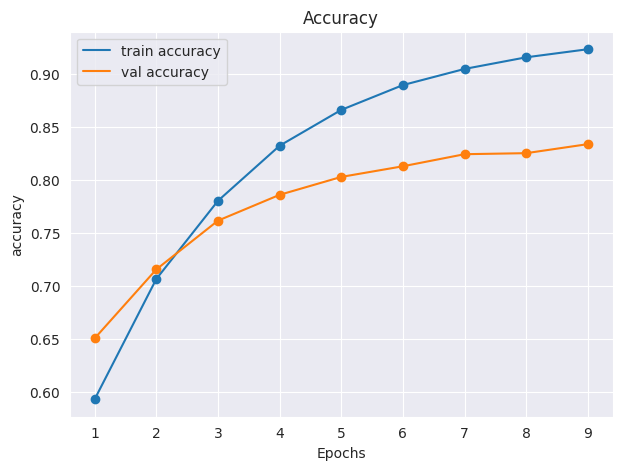

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_acc , label='train accuracy')
plt.scatter(range(1,10),epoch_tr_acc)
plt.plot(range(1,10),epoch_vl_acc , label='val accuracy')
plt.scatter(range(1,10),epoch_vl_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

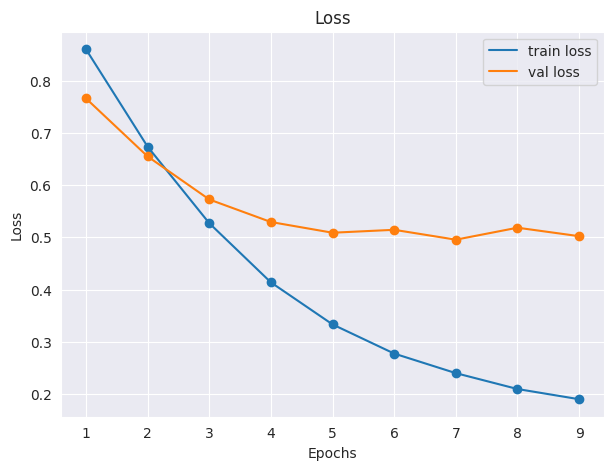

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_loss , label='train loss')
plt.scatter(range(1,10),epoch_tr_loss )
plt.plot(range(1,10),epoch_vl_loss , label='val loss')
plt.scatter(range(1,10),epoch_vl_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Évaluation du modèle BiLSTM**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Passer le modèle en mode évaluation
model.eval()

all_preds = []
all_labels = []

# Prédire sur l'ensemble de validation
for data in valid_loader:
    inputs = data['text'].to(device, dtype=torch.long)
    labels = data['target'].to(device, dtype=torch.float)

    # Obtenir les prédictions du modèle
    outputs = model(inputs)
    preds = torch.argmax(outputs, axis=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

# **Rapport de classification du modèle BiLSTM**




In [ ]:
from sklearn.metrics import classification_report

# Correspondance des étiquettes :
# 'Positive' : 1, 'Negative' : 0, 'Neutral' : 2, 'Irrelevant' : 2

print("Rapport de classification :")
print(classification_report(
    all_labels,
    all_preds,
    target_names=['Negative', 'Positive', 'Neutral/Irrelevant']
))


Rapport de classification :
                    precision    recall  f1-score   support

          Negative       0.87      0.82      0.84      4331
          Positive       0.82      0.80      0.81      3933
Neutral/Irrelevant       0.83      0.87      0.85      6040

          accuracy                           0.84     14304
         macro avg       0.84      0.83      0.83     14304
      weighted avg       0.84      0.84      0.84     14304



# **Matrice de confusion du modèle BiLSTM**

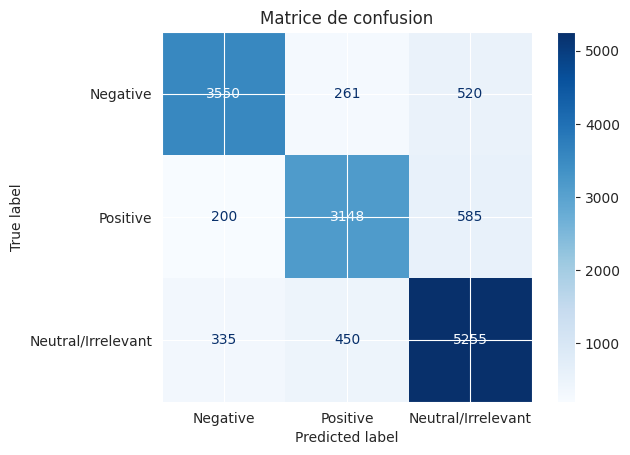

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Negative', 'Positive', 'Neutral/Irrelevant']
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


# **Prédiction**



In [ ]:
# Phrase à tester
test_sentence = "This product is amazing and I highly recommend it!"

# Prétraitement : tokenisation et padding
test_sequence = tokenizer.texts_to_sequences([test_sentence])
test_sequence = tf.keras.preprocessing.sequence.pad_sequences(test_sequence, maxlen=MAX_LEN)

# Conversion en tenseur
test_tensor = torch.tensor(test_sequence, dtype=torch.long).to(device)

# Prédiction
model.eval()
with torch.no_grad():
    output = model(test_tensor)
    predicted_class = torch.argmax(output, axis=1).item()

# Mapping des classes
sentiment_labels = {0: "Negative", 1: "Positive", 2: "Neutral/Irrelevant"}

# Résultat
print(f"Phrase : \"{test_sentence}\"")
print(f"Sentiment prédit : {sentiment_labels[predicted_class]}")


Phrase : "This product is amazing and I highly recommend it!"
Sentiment prédit : Positive


# **BERT**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Charger le tokenizer et le modèle préentraîné
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer


# Séparer les données en ensembles d'entraînement et de validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Text'].tolist(), df['sentiments'].tolist(), test_size=0.2, random_state=42
)

# Tokeniser les textes
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


In [ ]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Créer les datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


# **Training the BERT Model**

In [ ]:
from transformers import AdamW

# Optimiseur
optimizer = AdamW(model.parameters(), lr=5e-5)


In [ ]:
from torch.utils.data import DataLoader
from transformers import get_scheduler

# Charger les datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [ ]:
# Scheduler d'apprentissage
num_training_steps = len(train_loader) * 3  # Nombre d'époques = 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Entraînement
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

from tqdm import tqdm

epochs = 3
for epoch in range(1, epochs + 1):  # Démarrer à 1 au lieu de 0
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        # Déplacer les données vers le GPU/CPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Calculer la perte
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Mettre à jour le scheduler
        lr_scheduler.step()

        # Mise à jour des statistiques d'entraînement
        train_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        correct_train += (predictions == batch['labels']).sum().item()
        total_train += batch['labels'].size(0)

        # Mise à jour de la barre de progression
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

    # Calcul des métriques d'entraînement pour l'époque
    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train

    # Évaluation après chaque époque
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            # Mise à jour des statistiques de validation
            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct_val += (predictions == batch['labels']).sum().item()
            total_val += batch['labels'].size(0)

    # Calcul des métriques de validation pour l'époque
    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val

    # Afficher les résultats après chaque époque
    print(f"Epoch {epoch} Results:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1: 100%|██████████| 448/448 [17:37<00:00,  2.36s/it, loss=0.533]


Epoch 1 Results:
  Train Loss: 0.7475, Train Accuracy: 0.6628
  Val Loss: 0.5086, Val Accuracy: 0.7958


Epoch 2: 100%|██████████| 448/448 [17:35<00:00,  2.36s/it, loss=0.184]


Epoch 2 Results:
  Train Loss: 0.3535, Train Accuracy: 0.8639
  Val Loss: 0.3112, Val Accuracy: 0.8840


Epoch 3: 100%|██████████| 448/448 [17:34<00:00,  2.35s/it, loss=0.111]


Epoch 3 Results:
  Train Loss: 0.1669, Train Accuracy: 0.9361
  Val Loss: 0.2882, Val Accuracy: 0.9002


# **Affichage des courbes de loss et d'accuracy du modèle BERT**

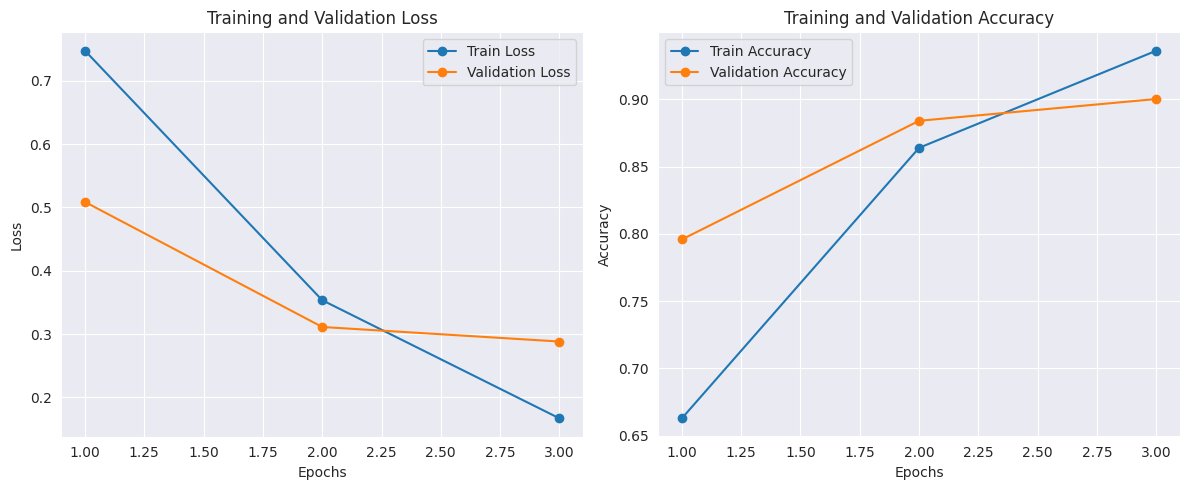

In [ ]:
import matplotlib.pyplot as plt

# Données extraites des résultats
train_losses = [0.7475, 0.3535, 0.1669]
train_accuracies = [0.6628, 0.8639, 0.9361]
val_losses = [0.5086, 0.3112, 0.2882]
val_accuracies = [0.7958, 0.8840, 0.9002]

# Nombre d'époques
epochs = range(1, len(train_losses) + 1)

# Tracé des courbes
plt.figure(figsize=(12, 5))

# Courbe de Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Courbe d'Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# **Calcul des métriques détaillées du modèle BERT**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Évaluation après l'entraînement pour obtenir des métriques détaillées
all_predictions = []
all_labels = []

model.eval()  # Mode évaluation
with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Stocker les prédictions et les vraies étiquettes
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Calcul des métriques globales
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print("Metrics on Validation Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Metrics on Validation Set:
Accuracy: 0.9002
Precision: 0.9009
Recall: 0.9002
F1 Score: 0.9001


# **Matrice de confusion du modèle BERT**

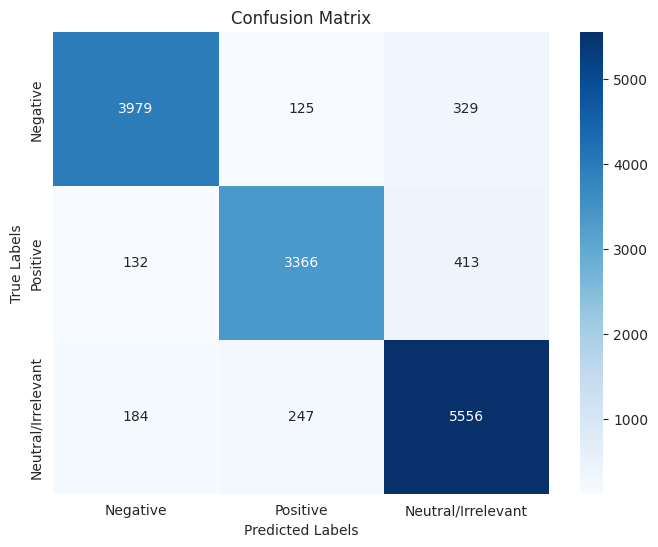

In [ ]:
# Matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_labels.values(), yticklabels=sentiment_labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Le modèle BERT surpasse LSTM en termes de précision, de rappel et de score F1, grâce à sa capacité à saisir le contexte bidirectionnel et à gérer des relations complexes entre les mots. BERT excelle dans l'identification des sentiments nuancés, en particulier dans les classes Neutral/Irrelevant, offrant une performance globale plus élevée (environ 87–91% d'exactitude contre 84% pour LSTM). En revanche, LSTM est plus léger et rapide, mais moins performant sur des tâches complexes, car il capture moins bien les dépendances à long terme et les subtilités contextuelles. Enfin, **BERT est plus adapté pour des données volumineuses et des tâches d'analyse de sentiment difficiles.**